# Generate scaled graph 

We scale the graph to make the size of each district proportional to its population. To do so, we use make Stochastic Block Model network, and we fit the parameters to make an SIR epidemic spreading over the network statistically look like the projected number of Ebola cases from the study [Ebola Virus Disease in West Africa — The First 9 Months of the Epidemic and Forward Projections](https://www.nejm.org/doi/full/10.1056/NEJMoa1411100) (See projections in Suppl. material 2).

In particular, we match the doubling time for the initial exponential growth of the epidemic.

The parameters are:
* `n_nodes`: the size of the network
* `p_in`: the intra-district probability 
* `p_ou`: the inter-district probability

---

Load libs.

In [1]:
%load_ext autoreload
%autoreload 2

Add the project base directory to the path

In [2]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import networkx as nx

from graph_generation import make_ebola_network
from dynamics import SIRDynamicalSystem
import helpers

---

## Define SIR epidemic parameters

We use the values estimated from the literature

In [4]:
beta = 1.0 / 15.3  # Serial interval time (from literature)
delta = 1.0 / 11.4  # Course of infection (from literature)

## Build propagation network

Set the stochastic block model network parameters

In [5]:
n_nodes = 10000
p_in = 0.01
p_out = p_in / 10

Generate the graph

In [6]:
graph = make_ebola_network(n_nodes=n_nodes, p_in=p_in, p_out=p_out)
A = nx.adjacency_matrix(graph).toarray()
n_nodes = graph.number_of_nodes()
print('Graph generated')
print(graph.number_of_nodes(), graph.number_of_edges())

Graph generated
8907 18312


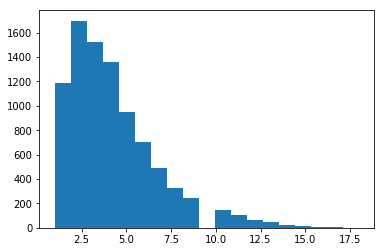

In [7]:
degree_sequence = [d for n, d in graph.degree()]
max_deg = max(degree_sequence)
plt.hist(degree_sequence, bins=max_deg+1);

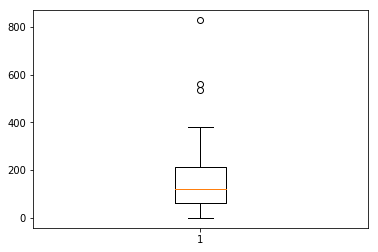

In [8]:
cluster_sizes = np.bincount([d['block'] for u,d in graph.nodes(data=True)])
plt.boxplot(cluster_sizes);

---

## Run simulation on the network to validate the parameters

Extract initial infections in districts based on data set.

In [9]:
def sample_seeds(n_seeds=None, max_date=None, verbose=True):
    """
    Extract seeds from the Ebola cases datasets, by choosing either:
    * the first `n_seeds`. 
    * the first seed until the date `max_date`.
    We then simulate the recovery rate of the seed, and start
    the epidemics at the infection time of the last seed.
    Note that some seeds may have already recovered at this time. In 
    this case, they are just ignored from the simulation.
    """
    assert (n_seeds is None) or (max_date is None)
    
    # Load real data
    df = pd.read_csv('../data/ebola/rstb20160308_si_001_cleaned.csv')
    if n_seeds:
        df = df.sort_values('infection_timestamp').iloc[:n_seeds]
    elif max_date:
        df = df[df.infection_date < max_date].sort_values('infection_timestamp')
        
    # Extract the seed disctricts
    seed_names = list(df['district'])
    
    # Extract district name for each node in the graph
    node_names = np.array([u for u, d in graph.nodes(data=True)])
    node_districts = np.array([d['district'] for u, d in graph.nodes(data=True)])
    
    # Get last infection time of seeds (this is time zero for the simulation)
    last_inf_time = df.infection_timestamp.max()
    
    # Init list of seed events
    init_event_list = list()
    for _, row in df.iterrows():
        
        inf_time = row['infection_timestamp']
        
        # Sample recovery time
        rec_time = inf_time + np.random.exponential(1./delta) - last_inf_time
        
        # Ignore seed if recovered before time zero
        if rec_time > 0:
            
            # Randomly sample one node for each seed in the corresponding district
            idx = np.random.choice(np.where(node_districts == row['district'])[0])
            node = node_names[idx]
            
            # Add infection event 
            # node to node infection flags initial seeds in code
            init_event_list.append([(node, 'inf', node), 0.0])  # Gets infection at the start 
            
            # Add recovery event
            init_event_list.append([(node, 'rec', None), rec_time])  
            
            if verbose:
                print(f'Add seed {node} from district {row["district"]} - inf: {0.0}, rec: {rec_time} ')
    return init_event_list

In [10]:
init_event_list = sample_seeds(max_date='2014-02-26', verbose=False)
init_event_list

[[(2032, 'inf', 2032), 0.0],
 [(2032, 'rec', None), 2.297907170190882],
 [(2147, 'inf', 2147), 0.0],
 [(2147, 'rec', None), 2.9418012109558305],
 [(2196, 'inf', 2196), 0.0],
 [(2196, 'rec', None), 17.810300181101667],
 [(1943, 'inf', 1943), 0.0],
 [(1943, 'rec', None), 2.1032236940220272],
 [(2152, 'inf', 2152), 0.0],
 [(2152, 'rec', None), 57.3526266037436],
 [(2132, 'inf', 2132), 0.0],
 [(2132, 'rec', None), 5.4120667189316976],
 [(1996, 'inf', 1996), 0.0],
 [(1996, 'rec', None), 2.0341866657393837],
 [(7069, 'inf', 7069), 0.0],
 [(7069, 'rec', None), 2.186765098634133],
 [(2016, 'inf', 2016), 0.0],
 [(2016, 'rec', None), 5.296852920887616],
 [(599, 'inf', 599), 0.0],
 [(599, 'rec', None), 12.311728791961286]]

In [16]:
# from epidemics_helper import SimulationSIR
from dynamics_ind import SimulationSIR, PriorityQueue
# from dynamics_ind_v1 import SimulationSIR, PriorityQueue

# param_dict = {
#     'beta':  1.0/15.3,
#     'gamma': 1.0/30.6,
#     'delta': 1.0/11.4,
#     'rho':   -1.0/22.8,
#     'eta':   1.0
# }

param_dict = {
    'beta':  1.0/15.3,
    'gamma': 1.0/30.6,
    'delta': 1.0/11.4,
    'rho':   -1.0/22.8,
    'eta':   1.0
}

policy_dict = {
    'TR' : 0.1,
}

sir = SimulationSIR(graph, param_dict=param_dict, verbose=True)


sir.launch_epidemic(init_event_list=init_event_list, max_time=10 * 7, policy='TR', policy_dict=policy_dict)


Epidemic spreading... 53.10 days elapsed | 77.7% susceptible, 22.3% infected, 9.4% treated, 14.4% recovered

KeyboardInterrupt: 

In [ ]:
%debug


In [ ]:
def plot_populations(sir_obj, tfreq=100):
    
    plt.figure()
    tspace = np.linspace(0, sir_obj.max_time, tfreq)
    
    susceptible, infected, removed, treated = [], [], [], []
    for t in tspace:
        susceptible.append(np.sum(sir_obj.nodes_at_time('S', t)))
        infected.append(np.sum(sir_obj.nodes_at_time('I', t)))
        removed.append(np.sum(sir_obj.nodes_at_time('R', t)))
        treated.append(np.sum(sir_obj.nodes_at_time('T', t)))
        
    # plt.plot(tspace, susceptible, label='Susceptible', color='black')
    plt.plot(tspace, infected, label='Infected', color='red')
    plt.plot(tspace, removed, label='Removed', color='green')
    plt.plot(tspace, treated, label='Treatment', color='blue')
    plt.xlabel('days')
    plt.ylabel('population')
    plt.yscale('log')
    plt.legend();
    return
    
    
plot_populations(sir, tfreq=100)   

---

### 1. Run simulations on the early epidemic to validate the network

We start with seeds until Feb 26, 2014 and run the epidemic for a couple months. At this time, we expect that there was no control measures affecting the epidemic parameters.

We verify that the empirical value of $R_0$ (i.e. the average number of secondary cases infected by primary infections) roughly matches the observed values of $1.5 < R_0 < 2$. 

In [ ]:
sim_dict = {
    'total_time': 70.0,
    'trials_per_setting': 1
}
n_seeds = 30
X_init = sample_seeds(graph, n_seeds=n_seeds)
system = SIRDynamicalSystem(X_init, A, param_dict, cost_dict, debug=False, verbose=True, notebook=True)

In [ ]:
data = system.simulate_policy('NO', baselines_dict, sim_dict, plot=False)

In [ ]:
def estimate_Rt():
    # TODO
    pass


In [ ]:
# data2 = system.simulate_policy('SOC', baselines_dict, sim_dict, plot=False)

---

### 2. Run simulations on in the latter part of the epidemic to validate the intervention parameters.

Run simulations starting in September 2014, and verify that the rate of infection roughly matches the projections estimated in the literature.

Projected number of cases each week starting on September 8, 2014. (Mean, 5% CI, 95% CI)

In [ ]:
expected_projection = np.array([
    [1215, 798, 1905],
    [1555, 942, 2654],
    [2042, 1145, 3792],
    [2738, 1419, 5529],
    [3727, 1808, 8126],
    [5153, 2351, 12082],
    [7202, 3081, 18043],
    [10122, 4083, 27159],
    [14272, 5463, 40942],
    [20213, 7349, 61766],
    [28752, 9896, 93011]
])

n_weeks = len(expected_projection)

Set values for the intervation parameters

In [ ]:
# gamma = 0.6 / 15.3  # Reduction in infection rate of neighbors under treatment
# rho = -0.3 / 11.4 # Recovery rate from treatment (if negative, then treatment means longer infections, and/or die less quickly)


gamma = 0.9 / 15.3  # Reduction in infection rate of neighbors under treatment
rho = -0.0 / 11.4 # Recovery rate from treatment (if negative, then treatment means longer infections, and/or die less quickly)


Save the network in `json` format.

In [ ]:
# import json
# from networkx.readwrite import json_graph

# with open('../data/ebola/ebola_scaled_graph.json', 'w') as f:
#     graph_data = json_graph.node_link_data(graph)
#     graph_data['graph']['partition'] = list(map(list, graph_data['graph']['partition'])) # Fix json compatibility by casting set to list
#     json.dump(graph_data, f)